In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

import scienceplots
plt.style.use(['science', 'no-latex'])

In [2]:
def response(W, B, dI):
    """
    W : weight matrix
    I : input (dI)
    B: diagonal matrix of cellular gains
    """

    if np.linalg.det(B) == 0:
        # print("Matrix B is singular, cannot compute its inverse.")
        return np.nan, np.nan
    
    A = np.linalg.inv(B) - W

    if np.linalg.det(A) == 0:
        # print("Matrix A is singular, cannot compute its inverse.")
        return np.nan, np.nan
    R = np.linalg.inv(A)
    
    R_l = R[0] @ dI
    R_e = R[1] @ dI

    return R_l, R_e

def determinant(W, B):
    """
    Compute the determinant of the matrix A = inv(B) - W
    where B is the diagonal matrix of cellular gains
    and W is the weight matrix
    
    This determinant is the denominator of the response functions
    """
    if np.linalg.det(B) == 0:
        # print("Matrix B is singular, cannot compute its inverse.")
        return np.nan
    A = np.linalg.inv(B) - W
    det = np.linalg.det(A)
    return det

def dynamics(W, I, tau=np.ones(4), dt=0.01, duration=5):
    """
    Compute the dynamics of the system given by:
    dR/dt = -R + f(WR + I)
    where f is the linear transfer function with gain B
    """

    r = np.zeros((W.shape[0], int(duration/dt)))

    for t in range(1, r.shape[1]):
        r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))

    return r

    
def transfer_function(input):
    output = (1/4) * input**2
    return output

def ext_input(bg_l, bg_e, bg_p, bg_c, duration, dt, t_on, amp, tau_l, tau_e, tau_p, tau_c):
    """
    create the external input vector as a numpy array
    where at specified time, the input increases from baseline to a higher value
    in an exponentially decaying manner
    """

    I = np.array([bg_l, bg_e, bg_p, bg_c], dtype=float)

    for t in np.arange(0, duration, dt):
        if t >= t_on:
            I[0] = bg_l + amp * np.exp(-(t - t_on)/tau_l)
            I[1] = bg_e + amp * np.exp(-(t - t_on)/tau_e)
            I[2] = bg_p + amp * np.exp(-(t - t_on)/tau_p)
            I[3] = bg_c + amp * np.exp(-(t - t_on)/tau_c)
        else:
            I[0] = bg_l
            I[1] = bg_e
            I[2] = bg_p
            I[3] = bg_c

    return I

def ext_input_const(bg_l=1, bg_e=1, bg_p=1, bg_c=1):
    """
    create the external input vector as a numpy array
    where the input is constant
    """

    I = np.array([bg_l, bg_e, bg_p, bg_c], dtype=float)

    return I

def ss_gain(W, r_ss, I):
    """
    Compute the steady state gain of the system
    given the weight matrix W and the steady state rates r, and the input to the system I

    assumes that the transfer function = f(input) = (input^2)/4
    """
    B_ss = np.diag((W @ r_ss + I)/2)
    return B_ss

def response_regime_metric(R_l, R_e):
    """
    Compute the response regime metric
    defined as the ratio of the change in R_e to the change in R_l
    """

    if R_l > 0 and R_e > 0: # training
        return 0
    elif R_l > 0 and R_e <= 0: # early recall
        return 1
    elif R_l <= 0 and R_e > 0: # late recall
        return 2
    else: # no response
        return 3
    

(4, 500)


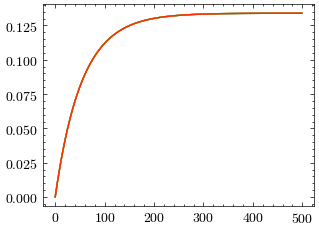

In [3]:
# plot dynamics for sanity check
# --- IGNORE ---
# --- IGNORE ---
J = 1.0
g = 2.0
W = np.array([[J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J]])
input = ext_input_const()
r = dynamics(W, input, duration=5)
print(r.shape)
plt.plot(r.T)
# --- IGNORE ---
# --- IGNORE ---    

In [4]:
# Connectivity no - 1

def exc_vs_inh_simple(J, g, I_l, I_e, I_p, I_c):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        all inhibitory weights : g*J
    """
    W = np.array([[J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 2

def inh_PV_CCK(J, g_p, g_c, I_l, I_e , I_p, I_c):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        inhibitory weights from PV : g_p*J
        inhibitory weights from CCK : g_c*J
    """
    W = np.array([[J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 3
def inh_PV_diff(J, g_p, g_c, alpha_p, beta_p, I_l, I_e, I_p, I_c):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
            - to late born exc neurons : alpha_p*g_p*J
            - to early born exc neurons : beta_p*g_p*J
        CCK inhibitory weights : g_c*J
    """
    W = np.array([[J, J, -alpha_p*g_p*J, -g_c*J],
                  [J, J, -beta_p*g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 4
def inh_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
        CCK inhibitory weights : g_c*J
            - to late born exc neurons : alpha_c*g_c*J
            - to early born exc neurons : beta_c*g_c*J
    """
    W = np.array([[J, J, -g_p*J, -alpha_c*g_c*J],
                  [J, J, -g_p*J, -beta_c*g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 5
def inh_PV_diff_CCK_diff(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
            - to late born exc neurons : alpha_p*g_p*J
            - to early born exc neurons : beta_p*g_p*J
        CCK inhibitory weights : g_c*J
            - to late born exc neurons : alpha_c*g_c*J
            - to early born exc neurons : beta_c*g_c*J
    """
    W = np.array([[J, J, -alpha_p*g_p*J, -alpha_c*g_c*J],
                  [J, J, -beta_p*g_p*J, -beta_c*g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det


In [ ]:
# explore connectivity no - 1
@widgets.interact(I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_exc_vs_inh_simple(I_l, I_e, I_p, I_c, v_min, v_max):

    J_arr = np.linspace(0, 2, 50)
    g_arr = np.linspace(0, 5, 50)

    R_l = np.zeros((len(J_arr), len(g_arr)))
    R_e = np.zeros((len(J_arr), len(g_arr)))
    determinant_grid = np.zeros((len(J_arr), len(g_arr)))
    response_regime = np.zeros((len(J_arr), len(g_arr)))

    for i, J in enumerate(J_arr):
        for j, g in enumerate(g_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = exc_vs_inh_simple(J, g, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$J$')
    ax[0].set_ylabel(r'$g$')
    fig.colorbar(im1, ax=ax[0])

    # add dashed white line at determinant = 0
    cx = ax[0].contour(J_arr, g_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$J$')
    ax[1].set_ylabel(r'$g$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(J_arr, g_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$J$')
    ax[2].set_ylabel(r'$g$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(J_arr, g_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$J$')
    ax[3].set_ylabel(r'$g$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Exc vs Inh simple ($g$ vs $J$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='I_l', max=2.0, min=-1.0, step=0.01), FloatSlider(val…

In [ ]:
# explore connectivity no - 2
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                    v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_inh_PV_CCK(J, I_l, I_e, I_p, I_c, v_min, v_max):

    g_p_arr = np.linspace(0, 5, 50)
    g_c_arr = np.linspace(0, 5, 50)

    R_l = np.zeros((len(g_p_arr), len(g_c_arr)))
    R_e = np.zeros((len(g_p_arr), len(g_c_arr)))
    determinant_grid = np.zeros((len(g_p_arr), len(g_c_arr)))
    response_regime = np.zeros((len(g_p_arr), len(g_c_arr)))

    for i, g_p in enumerate(g_p_arr):
        for j, g_c in enumerate(g_c_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_CCK(J, g_p, g_c, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$g_p$')
    ax[0].set_ylabel(r'$g_c$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(g_p_arr, g_c_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$g_p$')
    ax[1].set_ylabel(r'$g_c$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(g_p_arr, g_c_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$g_p$')
    ax[2].set_ylabel(r'$g_c$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(g_p_arr, g_c_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$g_p$')
    ax[3].set_ylabel(r'$g_c$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Inh PV and CCK ($g_p$ vs $g_c$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0, step=0.01), FloatSlider(value=1.0, desc…

In [ ]:
# Exploring connectivity no - 3
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_inh_PV_diff(J, g_p, g_c, I_l, I_e, I_p, I_c, v_min, v_max):
    
    alpha_p_arr = np.linspace(0, 4, 50)
    beta_p_arr = np.linspace(0, 4, 50)

    R_l = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    R_e = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    determinant_grid = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    response_regime = np.zeros((len(alpha_p_arr), len(beta_p_arr)))

    for i, alpha_p in enumerate(alpha_p_arr):
        for j, beta_p in enumerate(beta_p_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_diff(J, g_p, g_c, alpha_p, beta_p, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha_p$')
    ax[0].set_ylabel(r'$\beta_p$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_p_arr, beta_p_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$\alpha_p$')
    ax[1].set_ylabel(r'$\beta_p$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_p_arr, beta_p_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$\alpha_p$')
    ax[2].set_ylabel(r'$\beta_p$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_p_arr, beta_p_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha_p$')
    ax[3].set_ylabel(r'$\beta_p$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Inh PV diff ($\\alpha_p$ vs $\\beta_p$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0, step=0.01), FloatSlider(value=1.0, desc…

In [ ]:
# Exploring connectivity no - 4
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_inh_CCK_diff(J, g_p, g_c, I_l, I_e, I_p, I_c, v_min, v_max):
    
    alpha_c_arr = np.linspace(0, 4, 50)
    beta_c_arr = np.linspace(0, 4, 50)

    R_l = np.zeros((len(alpha_c_arr), len(beta_c_arr)))
    R_e = np.zeros((len(alpha_c_arr), len(beta_c_arr)))
    determinant_grid = np.zeros((len(alpha_c_arr), len(beta_c_arr)))
    response_regime = np.zeros((len(alpha_c_arr), len(beta_c_arr)))

    for i, alpha_c in enumerate(alpha_c_arr):
        for j, beta_c in enumerate(beta_c_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[alpha_c_arr[0], alpha_c_arr[-1], beta_c_arr[0], beta_c_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha_c$')
    ax[0].set_ylabel(r'$\beta_c$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_c_arr, beta_c_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[alpha_c_arr[0], alpha_c_arr[-1], beta_c_arr[0], beta_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$\alpha_c$')
    ax[1].set_ylabel(r'$\beta_c$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_c_arr, beta_c_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[alpha_c_arr[0], alpha_c_arr[-1], beta_c_arr[0], beta_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$\alpha_c$')
    ax[2].set_ylabel(r'$\beta_c$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_c_arr, beta_c_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[alpha_c_arr[0], alpha_c_arr[-1], beta_c_arr[0], beta_c_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha_c$')
    ax[3].set_ylabel(r'$\beta_c$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])
    
    fig.suptitle(f'Inh CCK diff ($\\alpha_c$ vs $\\beta_c$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0, step=0.01), FloatSlider(value=1.0, desc…

In [ ]:
# Exploring connectivity no - 5

@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  alpha_c = widgets.FloatSlider(value=1, min=0, max=4, step=0.1),
                  beta_c = widgets.FloatSlider(value=1, min=0, max=4, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_PV_diff_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, v_min, v_max):
    
    alpha_p_arr = np.linspace(0, 4, 50)
    beta_p_arr = np.linspace(0, 4, 50)

    R_l = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    R_e = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    determinant_grid = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    response_regime = np.zeros((len(alpha_p_arr), len(beta_p_arr)))

    for i, alpha_p in enumerate(alpha_p_arr):
        for j, beta_p in enumerate(beta_p_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_diff_CCK_diff(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha_p$')
    ax[0].set_ylabel(r'$\beta_p$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_p_arr, beta_p_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$\alpha_p$')
    ax[1].set_ylabel(r'$\beta_p$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_p_arr, beta_p_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$\alpha_p$')
    ax[2].set_ylabel(r'$\beta_p$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_p_arr, beta_p_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha_p$')
    ax[3].set_ylabel(r'$\beta_p$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response']) 

    fig.suptitle(f'Inh PV diff and CCK diff ($\\alpha_p$ vs $\\beta_p$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0, step=0.01), FloatSlider(value=1.0, desc…